In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

# Take our fixed pipeline

In [3]:
import os
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnableLambda

url = "https://e7f4684c-fd33-4db0-b1d3-268870ecb84d.europe-west3-0.gcp.cloud.qdrant.io:6333"
api_key = os.getenv("QDRANT_API_KEY")


client = QdrantClient(
    url=url,
    api_key=api_key,
    https=True,
    timeout=300
)

vector_store_page = QdrantVectorStore(
    client=client,
    collection_name="db-book-page",
    embedding=OpenAIEmbeddings(model="text-embedding-ada-002"),
)

In [ ]:

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage
from langchain_core.tools import tool, Tool


def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


@tool
def create_a_search_query(messages: list[AnyMessage]) -> str:
    """Based on the conversation creates a search query that serves for searching in a vector database
    Arguments:
        messages: conversation list
    Returns:
        search query: str
    """

    REPHRASOR_SYSTEM_PROMPT = """\
    Based on the conversation, your task is to create a "search query" that serves \
    as a query that can be used in a vector database to give most relevant information to answer the user's question.

    Constrains:
    - Create the search query only taking in account the conversation, avoid to add your knowledge.
    """

    ai_answer = llm.invoke([("system", REPHRASOR_SYSTEM_PROMPT)] + messages)

    return ai_answer.content

# search_query_tool = Tool.from_function(create_a_search_query)

@tool
def search_book_tool(query: str) -> str: #  Annotated[str, "description"]
    """Search tool that provides information about the book 'Fortaleza Digital'
    Arguments:
        query: string that is used for searching in a vector database
    Returns:
        context related to the query
    """

    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(query)


@tool
def create_a_friendly_answer(answer: str) -> str:
    """..."""


# Let's add as tools

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition


graph_builder = StateGraph(MessagesState)

tools = [create_a_search_query, search_book_tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: MessagesState):
    system_message = "siempre respondes de manera amigable, con emojis"
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

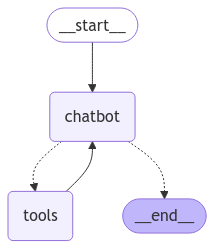

In [8]:
graph

In [6]:
result = graph.invoke({"messages": "quien es susan fletcher en el libro fortaleza digital?"})

In [7]:
result

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='fbe7d477-8e00-4894-a1c3-a1834439c83d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RBMDzNwZ7MRNUutN7oKAStIo', 'function': {'arguments': '{"messages":[{"content":"quien es susan fletcher en el libro fortaleza digital?","type":"human"}]}', 'name': 'create_a_search_query'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 3067, 'total_tokens': 3105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-49296be1-9627-4465-8876-3e8328a382ec-0', tool_calls=[{'name': 'create_a_sear

In [9]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

quien es susan fletcher en el libro fortaleza digital?
================================== Ai Message ==================================
Tool Calls:
  create_a_search_query (call_RBMDzNwZ7MRNUutN7oKAStIo)
 Call ID: call_RBMDzNwZ7MRNUutN7oKAStIo
  Args:
    messages: [{'content': 'quien es susan fletcher en el libro fortaleza digital?', 'type': 'human'}]
================================= Tool Message =================================
Name: create_a_search_query

Susan Fletcher personaje libro Fortaleza Digital
================================== Ai Message ==================================
Tool Calls:
  search_book_tool (call_TcP6w05Gs00ILWefqqUgnG1O)
 Call ID: call_TcP6w05Gs00ILWefqqUgnG1O
  Args:
    query: Susan Fletcher personaje libro Fortaleza Digital
================================= Tool Message =================================
Name: search_book_tool

Dan Brown
La fortaleza digital

Susan Fletcher,